Import Lib

In [271]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

In [272]:
load_dotenv()

True

LLM Models for all Indiviual task's

In [273]:
generatorLLM = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.7,
)

evaluatorLLM = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.3
)

optimizerLLM = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0.5
)


##### Structure Schema for Evaluation

In [274]:
class tweetEvaluationSchema(BaseModel):
  evaluation:Literal["approved", "need_improvement"] = Field(..., description="Final evaluation result")
  feedback:str = Field(..., description="Feedback for the tweet")

In [275]:
structureEvaluatorLLM = evaluatorLLM.with_structured_output(tweetEvaluationSchema)

## 1. State

In [276]:
class XTweetState(TypedDict):
  topic:str
  tweet:str
  evaluatePost:Literal["approved", "need_improvement"]
  feedback:str
  iteration:int
  maxIteration:int

  tweetHistory:Annotated[list[str], operator.add]
  feedbackHistory:Annotated[list[str], operator.add]

## 2. Defining the Function

##### 2.1 Generate the Tweet

In [277]:
def XtweetGenerator(state:XTweetState)->XTweetState:

  # prompt
  messages = [
    SystemMessage(content="You are a funny and clever Twitter/X influencer."),
    HumanMessage(content=f"""
  Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
  Rules:
  - Do NOT use question-answer format.
  - Max 280 characters.
  - Use observational humor, irony, sarcasm, or cultural references.
  - Think in meme logic, punchlines, or relatable takes.
  - Use simple, day to day english
  - This is version {state['iteration'] + 1}.
  """)
  ]

  # send to generatorLLM
  response = generatorLLM.invoke(messages).content
  return {'tweet':response, 'tweetHistory':[response]}

##### 2.2 Evaluate the Tweet

In [278]:
def XTweetEvaluator(state:XTweetState)->XTweetState:

  # prompt for evalution
   messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
   
   response = structureEvaluatorLLM.invoke(messages)
   return {'evaluatePost':response.evaluation, 'feedback':response.feedback, 'feedbackHistory':[response.feedback]}

##### 2.3 Optimize the Tweet

In [279]:
def XTweetOptimizer(state:XTweetState)->XTweetState:
  messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    """)
  ]
  response = optimizerLLM.invoke(messages).content
  iteration = state['iteration'] + 1

  return {'tweet':response, 'iteration':iteration, 'tweetHistory':[response]}

conditional check for Graph

In [280]:
def checkApprove(state:XTweetState):
  if state['evaluatePost'] == "approved" or state['iteration'] >= state['maxIteration']:
    return "approved"
  else:
    return "need_improvement"

## 3. Graph

In [281]:
graph = StateGraph(XTweetState)

graph.add_node('generateTweet', XtweetGenerator)
graph.add_node('evaluateTweet', XTweetEvaluator)
graph.add_node('optimizeTweet', XTweetOptimizer)

graph.add_edge(START, 'generateTweet')
graph.add_edge('generateTweet', 'evaluateTweet')

graph.add_conditional_edges('evaluateTweet', checkApprove, {'approved':END, 'need_improvement':"optimizeTweet"})
graph.add_edge('optimizeTweet', 'evaluateTweet')

workflow = graph.compile()

##### 3.1 Show the Workflow

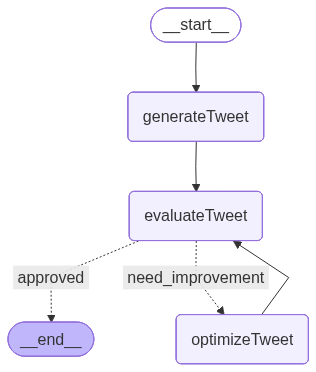

In [282]:
workflow

##### 3.2 Execute the Workflow

In [288]:
initalState = {
  'topic':"Corruption",
  'iteration': 1,
  'maxIteration':5
}

workflow.invoke(initalState)

{'topic': 'Corruption',
 'tweet': "My therapist told me to embrace my mistakes.  So I'm embracing this giant pile of suspiciously acquired cash.  #blessed #corruption #smallvictories",
 'evaluatePost': 'approved',
 'feedback': 'The tweet is original and humorous, with a good punchline.  The use of hashtags is also effective. The length is appropriate.  It has good virality potential due to its dark humor and relatable nature (though some may find it offensive).',
 'iteration': 1,
 'maxIteration': 5,
 'tweetHistory': ["My therapist told me to embrace my mistakes.  So I'm embracing this giant pile of suspiciously acquired cash.  #blessed #corruption #smallvictories"],
 'feedbackHistory': ['The tweet is original and humorous, with a good punchline.  The use of hashtags is also effective. The length is appropriate.  It has good virality potential due to its dark humor and relatable nature (though some may find it offensive).']}